In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gzip, pickle
import matplotlib as mpl
from pathlib import Path
import pandas as pd

mpl.rcParams['image.cmap'] = 'gray'

In [5]:
with gzip.open('./data/mnist.pkl.gz', 'rb') as f:
    data = pickle.load(f, encoding='latin')
((x_train, y_train), (x_val, y_val), _) = data
(x_train, y_train, x_val, y_val) = map(torch.tensor, (x_train, y_train, x_val, y_val) )

In [24]:
x_imgs = x_train.view(-1, 28, 28)
xval_imgs = x_val.view(-1, 28, 28)

img3 = im3 = x_imgs[7]
top_edges = torch.tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
]).float()

df = pd.DataFrame(img3[:13, :23])
df.style.background_gradient('gist_stern')

def apply_kernel(row, col, kernel):
    return (img3[row-1:row+2, col-1:col+2]*kernel).sum()

apply_kernel(14, 14, top_edges), (img3[13:16, 13:16]*top_edges).sum()

(tensor(0.2461), tensor(0.2461))

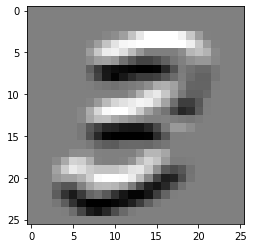

In [26]:
rng = range(1, 27)
top_edge3 = [[apply_kernel(i, j, top_edges) for j in rng] for i in rng]
plt.imshow(top_edge3)

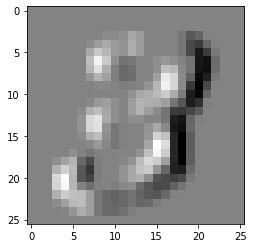

In [27]:
left_edges = torch.tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]g
]).float()
left_edge3 = [[apply_kernel(i, j, left_edges) for j in rng] for i in rng]
plt.imshow(left_edge3)

In [48]:
inp = im3[None,None,:]
w = left_edges.view(-1)
out = (w @ F.unfold(inp, (3, 3))[0]).view(-1, 26, 26)
out[0].shape

torch.Size([26, 26])

In [56]:
torch.allclose(out[0], torch.tensor(left_edge3))

True

In [60]:
out2 = F.conv2d(inp, left_edges[None,None,:])

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [62]:
torch.allclose(out2[0], torch.tensor(left_edge3))

True

In [66]:
out2[0].shape

torch.Size([1, 26, 26])

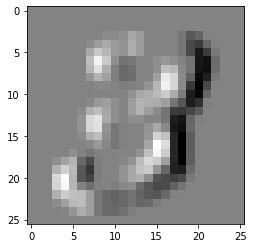

In [67]:
plt.imshow(out2[0][0].detach())

In [68]:
%timeit -n 1 [[apply_kernel(i, j, left_edges) for j in rng] for i in rng]

11.5 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
%timeit -n 100  (w @ F.unfold(inp, (3, 3))[0]).view(-1, 26, 26) 

89.6 µs ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
%timeit -n 100  F.conv2d(inp, left_edges[None,None,:])

71.5 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
diag1_edge = torch.tensor([
    [0, -1, 1],
    [-1, 1, 0],
    [1, 0, 0]
]).float()

diag2_edge = torch.tensor([
    [1, -1, 0],
    [0, 1, -1],
    [0, 0, 1]
]).float()

In [84]:
xb = x_imgs[:16][:,None]
edge_kernels = torch.stack([top_edges, left_edges, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [87]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

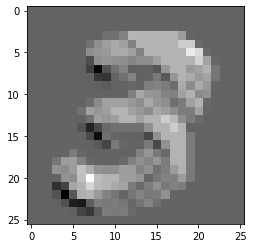

In [95]:
plt.imshow(batch_features[7][3])

In [98]:
n,m = x_train.shape
nh = 50
c = y_train.max()+1

broken_cnn = nn.Sequential(*[
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 10, kernel_size=3, padding=1)
])
t = broken_cnn(xb)
t.shape

torch.Size([16, 10, 28, 28])

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

simple_cnn = nn.Sequential(
    conv(1, 4), #14x14
    conv(4, 8), #7x7
    conv(8, 16), #2x2
    conv(16, 16), #1x1
    conv(16, 10, act=False),
    nn.Flatten()
)
t = simple_cnn(xb)
t.shape

In [105]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(*[res, nn.ReLU()])
    return res

simple_cnn = nn.Sequential(*[
    conv(1, 4), # 14x14
    conv(4, 8), # 7x7
    conv(8, 16), # 2x2
    conv(16, 16), # 1x1
    conv(16, 10, act=False),
    nn.Flatten()
])
t = simple_cnn(xb)

In [135]:
def of(w,p,s,f):
    print(f'(({w}-{f}+2*{p})/{s})+1')
    return ((w-f+2*p)/s)+1

In [145]:
w,p,s,f=7,0,1,3
of(w,p,s,f)

((7-3+2*0)/1)+1


5.0